In [40]:
pip install rasterio


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\Dodooz\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [41]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import random
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import f1_score, jaccard_score, accuracy_score, precision_score, recall_score
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.applications import ResNet50

In [42]:
# Set directory paths
images_dir = 'data/images'
labels_dir = 'data/labels'

# Image and mask dimensions
IMG_HEIGHT = 128
IMG_WIDTH = 128
NUM_BANDS = 12  # Number of spectral bands

In [43]:
# Function to load and normalize images and masks using rasterio
def load_images_and_masks(images_dir, labels_dir, normalization='min-max'):
    images, masks = [], []
    
    for file_name in os.listdir(images_dir):
        if file_name.endswith('.tif'):
            img_path = os.path.join(images_dir, file_name)
            mask_path = os.path.join(labels_dir, file_name.replace('.tif', '.png'))

            if not os.path.exists(mask_path):
                continue

            with rasterio.open(img_path) as src:
                image = src.read()
                image = np.transpose(image, (1, 2, 0))

            mask = plt.imread(mask_path)
            mask = (mask > 0).astype(np.uint8)  # Convert mask to binary

            if normalization == 'min-max':
                image = (image - np.min(image)) / (np.max(image) - np.min(image) + 1e-8)
            elif normalization == 'z-score':
                image = (image - np.mean(image)) / (np.std(image) + 1e-8)

            images.append(image)
            masks.append(mask)

    return np.array(images), np.array(masks)

In [44]:
# Load images and masks
images, masks = load_images_and_masks(images_dir, labels_dir, normalization='min-max')

C:\Users\Dodooz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [45]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)

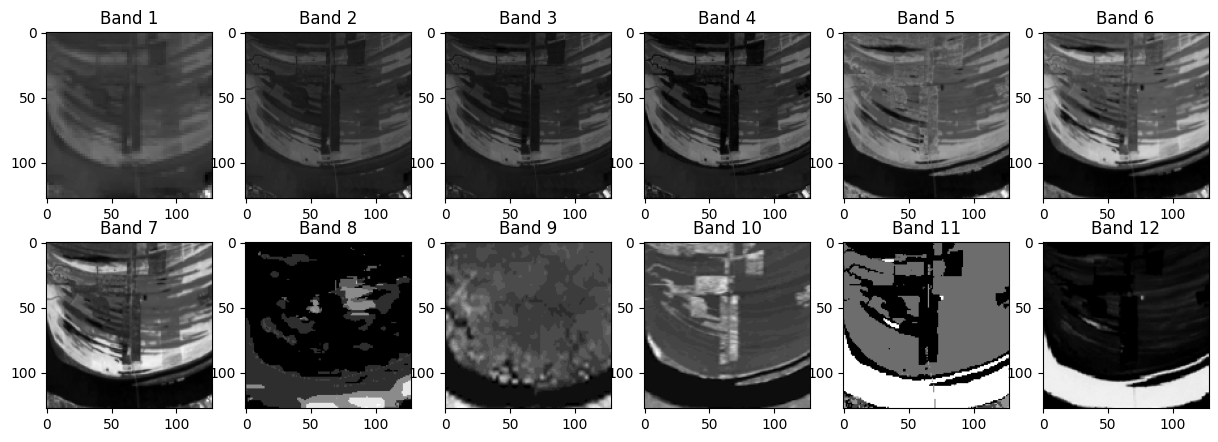

In [48]:
def visualize_bands(image, num_bands=12):
    plt.figure(figsize=(15, 5))
    for i in range(num_bands):
        plt.subplot(2, 6, i+1)
        plt.imshow(image[:, :, i], cmap='gray')
        plt.title(f'Band {i+1}')
    plt.show()

# Example usage:
visualize_bands(X_test[random.randint(0, len(X_test) - 1)])


In [28]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

def augment_image(image, mask):
    augmented = data_augmentation(image)
    return augmented, mask

X_train_aug, y_train_aug = zip(*[augment_image(img, mask) for img, mask in zip(X_train, y_train)])
X_train_aug = np.array(X_train_aug)
y_train_aug = np.array(y_train_aug)


In [29]:
def dice_loss(y_true, y_pred):
    smooth = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [30]:
# U-Net Model Architecture
def unet_model(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    b1 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    b1 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(b1)

    # Decoder
    u2 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(b1)
    u2 = layers.concatenate([u2, c2])
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u2)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)

    u3 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c3)
    u3 = layers.concatenate([u3, c1])
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u3)
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c4)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c4)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model



In [31]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, NUM_BANDS) # explicitly define input shape
model = unet_model(input_shape)

model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss=losses.BinaryCrossentropy(),
              metrics=[Precision(), Recall()])

In [32]:
# Train
history = model.fit(X_train, y_train, epochs=200, batch_size=8, validation_split=0.2)

Epoch 1/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - loss: 0.5394 - precision_1: 0.6203 - recall_1: 0.1651 - val_loss: 0.2807 - val_precision_1: 0.9574 - val_recall_1: 0.7159
Epoch 2/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 729ms/step - loss: 0.3558 - precision_1: 0.8865 - recall_1: 0.5779 - val_loss: 0.2936 - val_precision_1: 0.9667 - val_recall_1: 0.6387
Epoch 3/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 553ms/step - loss: 0.4149 - precision_1: 0.8931 - recall_1: 0.5301 - val_loss: 0.2575 - val_precision_1: 0.9014 - val_recall_1: 0.8253
Epoch 4/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 523ms/step - loss: 0.2897 - precision_1: 0.8991 - recall_1: 0.6904 - val_loss: 0.2269 - val_precision_1: 0.9498 - val_recall_1: 0.7673
Epoch 5/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 521ms/step - loss: 0.2974 - precision_1: 0.9064 - recall_1: 0.6708 - val_loss: 0.2418 - val_precision_1: 0.9571 - val_recall_1: 0.7448
Epoch 6/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 522ms/step - loss: 0.3045 - precision_1: 0.8963 - recall_1: 0.6398 - v

In [33]:
# Predict
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(np.uint8)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 761ms/step


In [34]:
# Evaluate
y_test_binary = y_test.astype(np.uint8)
y_test_flat = y_test_binary.flatten()
y_pred_flat = y_pred_binary.flatten()

precision = precision_score(y_test_flat, y_pred_flat, zero_division=1)
recall = recall_score(y_test_flat, y_pred_flat, zero_division=1)
f1 = f1_score(y_test_flat, y_pred_flat, zero_division=1)
iou = jaccard_score(y_test_flat, y_pred_flat)
accuracy = accuracy_score(y_test_flat, y_pred_flat)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"IoU: {iou:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Precision: 0.9283
Recall: 0.8562
F1 Score: 0.8907
IoU: 0.8030
Accuracy: 0.9529


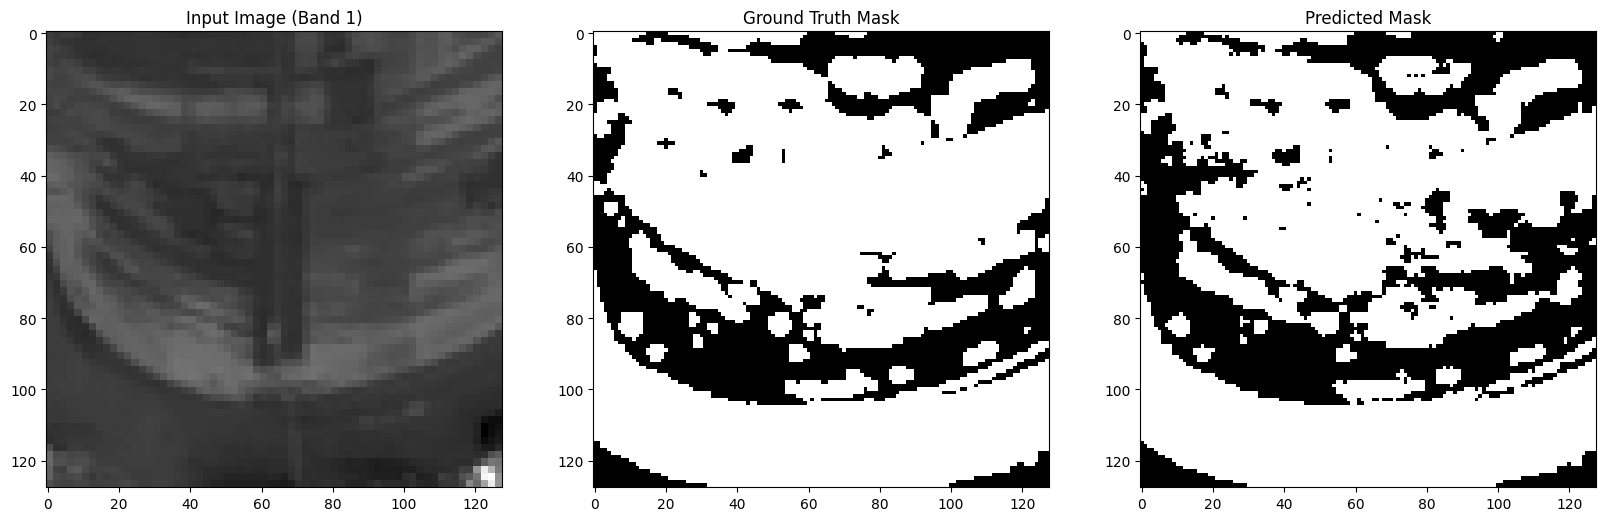

In [39]:
def visualize_random_prediction(X_test, y_test, y_pred_binary):
    """Randomly selects a sample and visualizes input image, ground truth mask, and prediction."""
    idx = random.randint(0, len(X_test) - 1)  # Select a random index

    plt.figure(figsize=(20, 10))
    
    plt.subplot(1, 3, 1)
    plt.imshow(X_test[idx][:, :, 0], cmap='gray')  # Display Band 1 of the image
    plt.title('Input Image (Band 1)')

    plt.subplot(1, 3, 2)
    plt.imshow(y_test[idx], cmap='gray')  # Ground Truth
    plt.title('Ground Truth Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(y_pred_binary[idx], cmap='gray')  # Prediction
    plt.title('Predicted Mask')

    plt.show()

# Call the function
visualize_random_prediction(X_test, y_test, y_pred_binary)